In [5]:
# abc_kinetic.py
from __future__ import annotations
from abc import ABC, abstractmethod ## abstract base class
from functools import partial
from typing import Callable, Tuple

import jax
import jax.numpy as jnp
from jax import random

import pandas as pd


# ---------------------------------------------------------------------
# 1.  Generic kinetic-model interface
# ---------------------------------------------------------------------
class KineticModel(ABC):
    """Abstract base: any forward model maps params → predicted TAC."""

    @abstractmethod
    def simulate(self,
                 params: jnp.ndarray,
                 Cp:     jnp.ndarray,
                 dt:     float) -> jnp.ndarray:
        """Forward model for a *single* parameter vector."""

    # Batch version is shared and fully vectorised
    def batch_simulate(self,
                       params: jnp.ndarray,
                       Cp_fine: jnp.ndarray,
                       dt: float,
                       A: jnp.ndarray | None = None) -> jnp.ndarray:
        """
        returns
            (N, T_fine) if A is None
            (N, F)      if A is provided
        """
        Ct_fine = jax.vmap(lambda θ: self.simulate(θ, Cp_fine, dt))(params)
        return Ct_fine if A is None else jnp.matmul(Ct_fine, A.T)   # note transpose


# ---------------------------------------------------------------------
# 2.  Concrete 2-tissue compartment model
# ---------------------------------------------------------------------
class TwoTissueModel(KineticModel):
    """
    5-parameter irreversible/reversible 2-TCM
        dC₁/dt = K₁·Cp  − (k₂+k₃)·C₁ + k₄·C₂
        dC₂/dt = k₃·C₁ − k₄·C₂
        C_T(t) = C₁ + C₂ + v_b·Cp
    Discretised with forward Euler for simplicity.  Pure JAX → XLA.
    """

    param_names = ('K1', 'k2', 'k3', 'k4', 'Vb', 'M')

    def simulate(self,
                 params: jnp.ndarray,
                 Cp:     jnp.ndarray,
                 dt:     float) -> jnp.ndarray:

        K1, k2, k3, k4, Vb, M = params

        def step(state, Cp_t):
            C1, C2 = state
            dC1 = K1 * Cp_t - (k2 + k3) * C1 + k4 * C2
            dC2 = k3 * C1 - k4 * C2
            C1_new = C1 + dC1 * dt
            C2_new = C2 + dC2 * dt
            Ct     = (1 - Vb) * (C1_new + C2_new) + Vb * Cp_t
            return (C1_new, C2_new), Ct

        (_, _), Ct = jax.lax.scan(step, (0.0, 0.0), Cp)
        return Ct


# ---------------------------------------------------------------------
# 3.  Vectorised, JIT-compiled rejection-ABC engine
# ---------------------------------------------------------------------
class ABCRejection:
    """
    Rejection ABC with a *fixed* number of simulations (N) and an
    acceptance fraction ε (keep ε·N best simulations).
    """

    def __init__(self,
                 model:          KineticModel,
                 prior_sampler:  Callable[[jax.random.KeyArray, int], jnp.ndarray],
                 distance_fn:    Callable[[jnp.ndarray, jnp.ndarray], float] | None = None,
                 num_sims:       int = 100_000,
                 accept_frac:    float = 0.01):
        self.model        = model
        self.prior_sampler = prior_sampler
        self.num_sims      = num_sims
        self.accept_frac   = accept_frac
        self.distance_fn   = (distance_fn if distance_fn is not None
                              else lambda x, y: jnp.sum(jnp.abs(x - y)))

    # -----------------------------------------------------------------
    # JIT-compiled single pass
    # -----------------------------------------------------------------
    @partial(jax.jit, static_argnums=(0,))   #  <-- self is static
    def _run_once(self,
                  rng_key:      jax.random.KeyArray,
                  observed_all: jnp.ndarray,
                  Cp_fine:      jnp.ndarray,
                  A:            jnp.ndarray,
                  dt:           float) -> jnp.ndarray:

        V = observed_all.shape[0]
        k = max(1, int(self.num_sims * self.accept_frac))

        # 1. Draw parameters
        rng_key, sub = jax.random.split(rng_key)
        params = self.prior_sampler(sub, self.num_sims)            # (N, P)

        # 2. Forward model once
        sim_curves = self.model.batch_simulate(params, Cp_fine, dt, A)  # (N, F)

        # 3. Distances to every voxel (broadcast)
        #     dists[n,v] = ||sim_curves[n] - observed_all[v]||²
        dists = jnp.sum(
            jnp.abs(sim_curves[:, None, :] - observed_all[None, :, :]), axis=-1
        )                                                         # (N, V)
        # 4. For each voxel pick k smallest distances
        vals, idxs = jax.lax.top_k((-dists).T, k)                 # (V, k)
        accepted   = jnp.take(params, idxs, axis=0)               # (V, k, P)
        return accepted

    # Public API
    def run(self,
            rng_key:      jax.random.KeyArray,
            observed_all: jnp.ndarray,
            Cp_fine:      jnp.ndarray,
            A:            jnp.ndarray,
            dt:           float = 1.0) -> jnp.ndarray:
        return self._run_once(rng_key, observed_all, Cp_fine, A, dt)


# ---------------------------------------------------------------------
# 4.  Preprocessing function for PET data
# ---------------------------------------------------------------------
def preprocess_table(df: pd.DataFrame,
                    dt_fine: float = 0.5
                    ) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    • df: rows exactly as specified above
    • returns
        Cp_fine   : (T_fine,)  – Cp sampled on the uniform fine grid
        A         : (F, T_fine) – frame-averaging sparse matrix (0/1 divided by n)
        tac_voxels: (V, F)     – all voxel TACs stacked
    """
    t_mid   = df.iloc[0].to_numpy(float)          # (F,)
    f_len   = df.iloc[1].to_numpy(float)          # (F,)
    Cp_raw  = df.iloc[2].to_numpy(float)          # (F,)
    TACs    = df.iloc[3:].to_numpy(float)         # (V, F)

    # Fine grid from t=0 to end of last frame
    t_end   = t_mid[-1] + 0.5 * f_len[-1]
    t_fine  = jnp.arange(0.0, t_end + dt_fine, dt_fine)   # (T_fine,)

    # Interpolate Cp onto fine grid (linear)
    Cp_fine = jnp.interp(t_fine, t_mid, Cp_raw)

    # Build sparse frame-averaging matrix A so that
    # Ct_frame = A @ Ct_fine
    starts = t_mid - 0.5 * f_len
    ends   = t_mid + 0.5 * f_len

    def build_row(t0, t1):
        mask = (t_fine >= t0) & (t_fine < t1)
        row  = mask.astype(float)
        # if no fine-grid samples fall inside the frame, fall back to
        # the closest sample to the mid-frame time
        row_sum = row.sum()
        return jax.lax.cond(
            row_sum == 0,
            lambda _: jax.nn.one_hot(jnp.argmin(jnp.abs(t_fine - 0.5*(t0+t1))),
                                    t_fine.size),
            lambda _: row / row_sum,
            operand=None
        )

    A = jax.vmap(build_row)(starts, ends)        # (F, T_fine)

    return Cp_fine, A, jnp.asarray(TACs), t_fine


# ---------------------------------------------------------------------
# 5.  Example prior (uniform box) and minimal demo
# ---------------------------------------------------------------------
def uniform_prior(key: jax.random.KeyArray, n: int) -> jnp.ndarray:
    """
    Draws n samples of length-6:
        [K1, k2, k3, k4, Vb, M]
    where M ~ Bernoulli(0.5) (0/1).
    Whenever M == 0, k4 is forced to 0. (irreversible model)

    Returns
    -------
    params : (n, 6)  jnp.ndarray
    """
    lows  = jnp.array([
        0.4, 
        0.3, 
        0.08, 
        0, 
        0.01
        ])
    highs = jnp.array([
        0.5, 
        0.4, 
        0.09, 
        0.1, 
        0.02
        ])

    key, sub_uniform = random.split(key)
    base = random.uniform(sub_uniform, shape=(n, 5), minval=lows, maxval=highs)

    # ─── Bernoulli indicator ─────────────────────────────────────────────
    key, sub_bern = random.split(key)
    ind = random.bernoulli(sub_bern, p=0.5, shape=(n, 1)).astype(base.dtype)  # (n,1)

    # If IND == 0  →  force k4 (column 3) to 0
    k4 = jnp.where(ind.squeeze() == 0, 0.0, base[:, 3])
    base = base.at[:, 3].set(k4)

    # ─── concatenate and return ─────────────────────────────────────────
    params = jnp.concatenate([base, ind], axis=1)        # (n, 6)
    return params

In [6]:
if __name__ == "__main__":
    import jax.random as jr
    import pandas as pd

    df = pd.read_csv("sample data.csv", header=None)

    # # Duplicate the last row (TAC data) 4999 times to create 5000 voxels
    # last_row = df.iloc[-1:].values  # Get the last row as array
    # duplicated_rows = pd.DataFrame([last_row[0]] * 100, columns=df.columns)
    # df = pd.concat([df, duplicated_rows], ignore_index=True)

    Cp_fine, A, voxel_tacs, t_fine = preprocess_table(df, dt_fine=0.5)  # (T_fine,), (F,T_fine), (V,F)

    model = TwoTissueModel()
    abc   = ABCRejection(model,
                         prior_sampler=uniform_prior,
                         num_sims=1_000_000,
                         accept_frac=48/1_000_000)

    key   = jr.PRNGKey(0)
    posterior = abc.run(key,
                        voxel_tacs,   # observed shape (F,)
                        Cp_fine,
                        A,                   # maps fine grid → frames
                        dt=0.5)
    print("Posterior:", posterior.shape)

Posterior: (1, 48, 6)


In [14]:
posterior_expectation = posterior.mean(axis=1)
posterior_expectation_df = pd.DataFrame(posterior_expectation, columns=model.param_names) ## M is irreversible probabability
posterior_expectation_df

,K1,k2,k3,k4,Vb,M
0,0.441022,0.302476,0.08768,0.00001,0.011056,0.020833


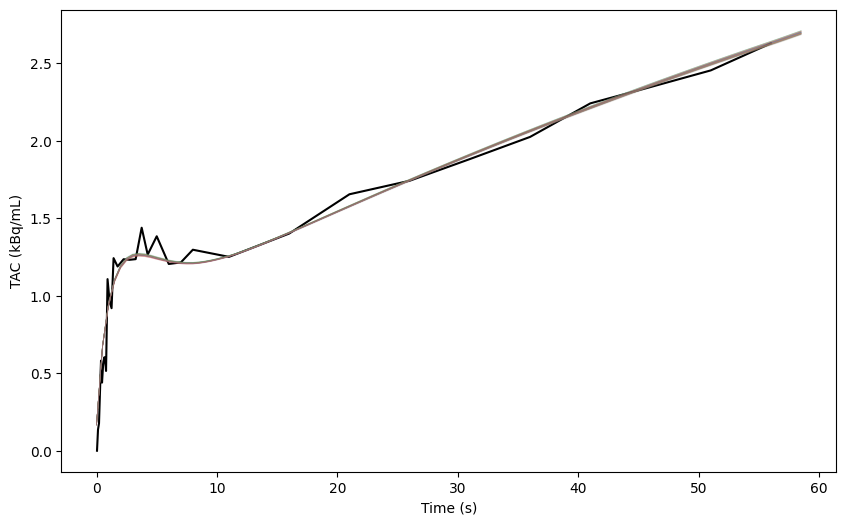

In [7]:
import matplotlib.pyplot as plt
voxel = 0
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[0], df.iloc[3 + voxel], label='Observed TAC', color='black')
for i in range(posterior.shape[1]):
    plt.plot(t_fine, model.simulate(posterior[voxel, i], Cp_fine, dt=0.5), label=f'Fitted TAC {i+1}', alpha=0.2, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('TAC (kBq/mL)')
# plt.legend()
plt.show()